Predicting California Property Close Price (Final Sales)

Datasets (latest 6 month):
- CRMLSSold202406_filled.csv
- CRMLSSold202407_filled.csv
- CRMLSSold202408.csv
- CRMLSSold202409.csv
- CRMLSSold202410.csv
- CRMLSSold202411.csv

Objective: The objective of this task is to develop a machine learning model that accurately predicts the close price (final sales price) of real estate properties based on their features. These features include living area, number of bedrooms, bathrooms, lot size, and other relevant property attributes from the CRMLS dataset.

About this notebook:

In [21]:
import pandas as pd
import glob
import os

# Define the directory
directory = "/Users/michellechen/Downloads/raw_California"

# Find all CSV files in the directory
data_files = glob.glob(os.path.join(directory, "*.csv"))

# Dictionary to store column sets for each file
file_columns = {}

for file in data_files:
    df = pd.read_csv(file, nrows=1)  # Read only the first row to get column names
    file_columns[file] = set(df.columns)

# Find the intersection of all columns (columns common to all files)
common_columns = set.intersection(*file_columns.values())

# Find columns unique to some files
unique_columns_per_file = {file: cols - common_columns for file, cols in file_columns.items()}

# Filter out files that have no unique columns
unique_columns_per_file = {file: cols for file, cols in unique_columns_per_file.items() if cols}

# Display the results
if unique_columns_per_file:
    print("Columns that appear in only some files:")
    for file, unique_cols in unique_columns_per_file.items():
        print(f"{os.path.basename(file)}: {unique_cols}")
else:
    print("All files have the same column structure.")

# Read and concatenate all CSV files, keeping only the common columns
crmls_data = pd.concat(
    (pd.read_csv(file, usecols=common_columns) for file in data_files),
    ignore_index=True
)

# Drop 'latfilled' and 'lonfilled' if they exist
columns_to_remove = {'latfilled', 'lonfilled'}
crmls_data.drop(columns=columns_to_remove.intersection(crmls_data.columns), inplace=True)

# Print dataset info
print(f"Successfully loaded {len(data_files)} files.")
print(crmls_data.info())


Columns that appear in only some files:
CRMLSSold202406_filled.csv: {'latfilled', 'lonfilled'}
CRMLSSold202407_filled.csv: {'latfilled', 'lonfilled'}
Successfully loaded 6 files.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139946 entries, 0 to 139945
Data columns (total 78 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   BuyerAgentAOR                 139889 non-null  object 
 1   ListAgentAOR                  139889 non-null  object 
 2   Flooring                      83572 non-null   object 
 3   ViewYN                        125553 non-null  object 
 4   WaterfrontYN                  60 non-null      object 
 5   BasementYN                    2450 non-null    object 
 6   PoolPrivateYN                 120314 non-null  object 
 7   OriginalListPrice             139608 non-null  float64
 8   ListingKey                    139946 non-null  int64  
 9   ListAgentEmail                139727 non-null

In [22]:
# Get the number of rows and columns
rows, columns = crmls_data.shape

# Print the result
print(f"The dataset has {rows} rows and {columns} columns.")

The dataset has 139946 rows and 78 columns.


Eliminated:
CRMLSSold202406_filled.csv: {'latfilled', 'lonfilled'}
CRMLSSold202407_filled.csv: {'latfilled', 'lonfilled'}

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Display initial information
print(crmls_data.info())
print(crmls_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139946 entries, 0 to 139945
Data columns (total 78 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   BuyerAgentAOR                 139889 non-null  object 
 1   ListAgentAOR                  139889 non-null  object 
 2   Flooring                      83572 non-null   object 
 3   ViewYN                        125553 non-null  object 
 4   WaterfrontYN                  60 non-null      object 
 5   BasementYN                    2450 non-null    object 
 6   PoolPrivateYN                 120314 non-null  object 
 7   OriginalListPrice             139608 non-null  float64
 8   ListingKey                    139946 non-null  int64  
 9   ListAgentEmail                139727 non-null  object 
 10  CloseDate                     139946 non-null  object 
 11  ClosePrice                    139945 non-null  float64
 12  ListAgentFirstName            138972 non-nul

1. Handling Missing Values

When to Drop a Column?

- High Percentage of Missing Values: If a column has more than ~40-50% missing values, it's often best to drop it unless it's critical for analysis.
- Low Information Value: If the column is unlikely to contribute significantly to predictions (e.g., BasementYN with only 2,450 non-null values out of 139,946).
- Alternative Features Exist: If another column provides similar or redundant information.

In the dataset, columns like WaterfrontYN (60 non-null out of 139,946) should likely be dropped.


When to Use Median Imputation?

- For Skewed Numerical Data: The median is robust to outliers, making it better for features like ListPrice, ClosePrice, and LivingArea which often have right-skewed distributions.


When to Use Mean Imputation?

- For Normally Distributed Numerical Data: If a feature follows a normal distribution, using the mean is appropriate since it preserves the overall distribution.


Handling Categorical Missing Values?

- Mode Imputation (Most Frequent Value): Used for categorical features like ViewYN, PoolPrivateYN, etc.
- "Unknown" or "None" Placeholder: If missing values indicate absence rather than a mistake, replace with "Unknown".



How to Identify Outliers?

- Use Boxplots:

plt.figure(figsize=(8, 5))
sns.boxplot(x=crmls_data['ClosePrice'])
plt.show()

- Use the IQR Rule:
- Outliers are values below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.

How to Handle Outliers?

- Clipping Extreme Values:
- If outliers are genuine (e.g., expensive luxury homes), cap extreme values at a reasonable threshold.

Q1 = crmls_data['ClosePrice'].quantile(0.25)
Q3 = crmls_data['ClosePrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

crmls_data['ClosePrice'] = np.clip(crmls_data['ClosePrice'], lower_bound, upper_bound)

- Log Transformation for Skewed Data:

crmls_data['ClosePrice'] = np.log1p(crmls_data['ClosePrice'])

In [5]:
# Get the original columns before dropping
original_columns = crmls_data.columns

# Drop columns with more than 50% missing values 
missing_threshold = 0.5 * len(crmls_data)
crmls_data = crmls_data.dropna(thresh=missing_threshold, axis=1)

# Get the new columns after dropping
remaining_columns = crmls_data.columns

# Find the dropped columns
dropped_columns = set(original_columns) - set(remaining_columns)

# Print the dropped columns
print(f"The following columns were dropped: {', '.join(dropped_columns)}")


The following columns were dropped: CoveredSpaces, ElementarySchoolDistrict, BuildingAreaTotal, ElementarySchool, MiddleOrJuniorSchool, BasementYN, CoListAgentFirstName, WaterfrontYN, MiddleOrJuniorSchoolDistrict, TaxAnnualAmount, SubdivisionName, LotSizeDimensions, AssociationFeeFrequency, BelowGradeFinishedArea, CoBuyerAgentFirstName, AboveGradeFinishedArea, FireplacesTotal, BusinessType, TaxYear, HighSchool, CoListAgentLastName, CoListOfficeName, BuilderName


In [6]:
# Get the number of rows and columns
rows, columns = crmls_data.shape

# Print the result
print(f"The dataset has {rows} rows and {columns} columns.")

The dataset has 139946 rows and 55 columns.


78 - 55 = 23 columns dropped: (more than 50% missing values)
BelowGradeFinishedArea, AssociationFeeFrequency, MiddleOrJuniorSchool, LotSizeDimensions, FireplacesTotal, BuilderName, CoveredSpaces, CoListAgentFirstName, ElementarySchoolDistrict, AboveGradeFinishedArea, CoBuyerAgentFirstName, HighSchool, TaxYear, TaxAnnualAmount, SubdivisionName, BasementYN, WaterfrontYN, CoListOfficeName, MiddleOrJuniorSchoolDistrict, BuildingAreaTotal, BusinessType, ElementarySchool, CoListAgentLastName

In [7]:
# Separate numerical and categorical columns
numerical_cols = crmls_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = crmls_data.select_dtypes(include=['object']).columns.tolist()

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Handle missing values
# Numerical columns: Fill with median
print("Numerical columns before imputation:", numerical_cols)
num_imputer = SimpleImputer(strategy='median')
crmls_data[numerical_cols] = num_imputer.fit_transform(crmls_data[numerical_cols])
print("Numerical columns after median imputation:", numerical_cols)

# Categorical columns: Fill with mode
print("Categorical columns before imputation:", categorical_cols)
cat_imputer = SimpleImputer(strategy='most_frequent')
crmls_data[categorical_cols] = cat_imputer.fit_transform(crmls_data[categorical_cols])
print("Categorical columns after mode imputation:", categorical_cols)

# Encode categorical variables
print("Categorical columns before encoding:", categorical_cols)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    crmls_data[col] = le.fit_transform(crmls_data[col])
    label_encoders[col] = le
print("Categorical columns after encoding:", categorical_cols)

# Scale numerical features
print("Numerical columns before scaling:", numerical_cols)
scaler = StandardScaler()
crmls_data[numerical_cols] = scaler.fit_transform(crmls_data[numerical_cols])
print("Numerical columns after scaling:", numerical_cols)


Numerical columns before imputation: ['OriginalListPrice', 'ListingKey', 'ClosePrice', 'Latitude', 'Longitude', 'LivingArea', 'ListPrice', 'DaysOnMarket', 'ListingKeyNumeric', 'ParkingTotal', 'LotSizeAcres', 'YearBuilt', 'StreetNumberNumeric', 'BathroomsTotalInteger', 'BedroomsTotal', 'Stories', 'LotSizeArea', 'MainLevelBedrooms', 'GarageSpaces', 'AssociationFee', 'LotSizeSquareFeet']
Numerical columns after median imputation: ['OriginalListPrice', 'ListingKey', 'ClosePrice', 'Latitude', 'Longitude', 'LivingArea', 'ListPrice', 'DaysOnMarket', 'ListingKeyNumeric', 'ParkingTotal', 'LotSizeAcres', 'YearBuilt', 'StreetNumberNumeric', 'BathroomsTotalInteger', 'BedroomsTotal', 'Stories', 'LotSizeArea', 'MainLevelBedrooms', 'GarageSpaces', 'AssociationFee', 'LotSizeSquareFeet']
Categorical columns before imputation: ['BuyerAgentAOR', 'ListAgentAOR', 'Flooring', 'ViewYN', 'PoolPrivateYN', 'ListAgentEmail', 'CloseDate', 'ListAgentFirstName', 'ListAgentLastName', 'UnparsedAddress', 'PropertyType

Numerical columns with Median imputation: ['OriginalListPrice', 'ListingKey', 'ClosePrice', 'Latitude', 'Longitude', 'LivingArea', 'ListPrice', 'DaysOnMarket', 'ListingKeyNumeric', 'ParkingTotal', 'LotSizeAcres', 'YearBuilt', 'StreetNumberNumeric', 'BathroomsTotalInteger', 'BedroomsTotal', 'Stories', 'LotSizeArea', 'MainLevelBedrooms', 'GarageSpaces', 'AssociationFee', 'LotSizeSquareFeet']
Categorical columns with mode imputation: ['BuyerAgentAOR', 'ListAgentAOR', 'Flooring', 'ViewYN', 'PoolPrivateYN', 'ListAgentEmail', 'CloseDate', 'ListAgentFirstName', 'ListAgentLastName', 'UnparsedAddress', 'PropertyType', 'ListOfficeName', 'BuyerOfficeName', 'ListAgentFullName', 'BuyerAgentMlsId', 'BuyerAgentFirstName', 'BuyerAgentLastName', 'MLSAreaMajor', 'CountyOrParish', 'MlsStatus', 'AttachedGarageYN', 'PropertySubType', 'BuyerOfficeAOR', 'ListingId', 'City', 'ContractStatusChangeDate', 'PurchaseContractDate', 'ListingContractDate', 'StateOrProvince', 'FireplaceYN', 'Levels', 'NewConstructionYN', 'HighSchoolDistrict', 'PostalCode']
Categorical columns with encoding: ['BuyerAgentAOR', 'ListAgentAOR', 'Flooring', 'ViewYN', 'PoolPrivateYN', 'ListAgentEmail', 'CloseDate', 'ListAgentFirstName', 'ListAgentLastName', 'UnparsedAddress', 'PropertyType', 'ListOfficeName', 'BuyerOfficeName', 'ListAgentFullName', 'BuyerAgentMlsId', 'BuyerAgentFirstName', 'BuyerAgentLastName', 'MLSAreaMajor', 'CountyOrParish', 'MlsStatus', 'AttachedGarageYN', 'PropertySubType', 'BuyerOfficeAOR', 'ListingId', 'City', 'ContractStatusChangeDate', 'PurchaseContractDate', 'ListingContractDate', 'StateOrProvince', 'FireplaceYN', 'Levels', 'NewConstructionYN', 'HighSchoolDistrict', 'PostalCode']
Numerical columns with scaling: ['OriginalListPrice', 'ListingKey', 'ClosePrice', 'Latitude', 'Longitude', 'LivingArea', 'ListPrice', 'DaysOnMarket', 'ListingKeyNumeric', 'ParkingTotal', 'LotSizeAcres', 'YearBuilt', 'StreetNumberNumeric', 'BathroomsTotalInteger', 'BedroomsTotal', 'Stories', 'LotSizeArea', 'MainLevelBedrooms', 'GarageSpaces', 'AssociationFee', 'LotSizeSquareFeet']

In [9]:
# Save cleaned dataset
## crmls_data.to_csv("cleaned_crmls_data.csv", index=False)

# Print a summary of missing values after cleaning
print("Missing values after cleaning:")
print(crmls_data.isnull().sum().sum())

Missing values after cleaning:
0


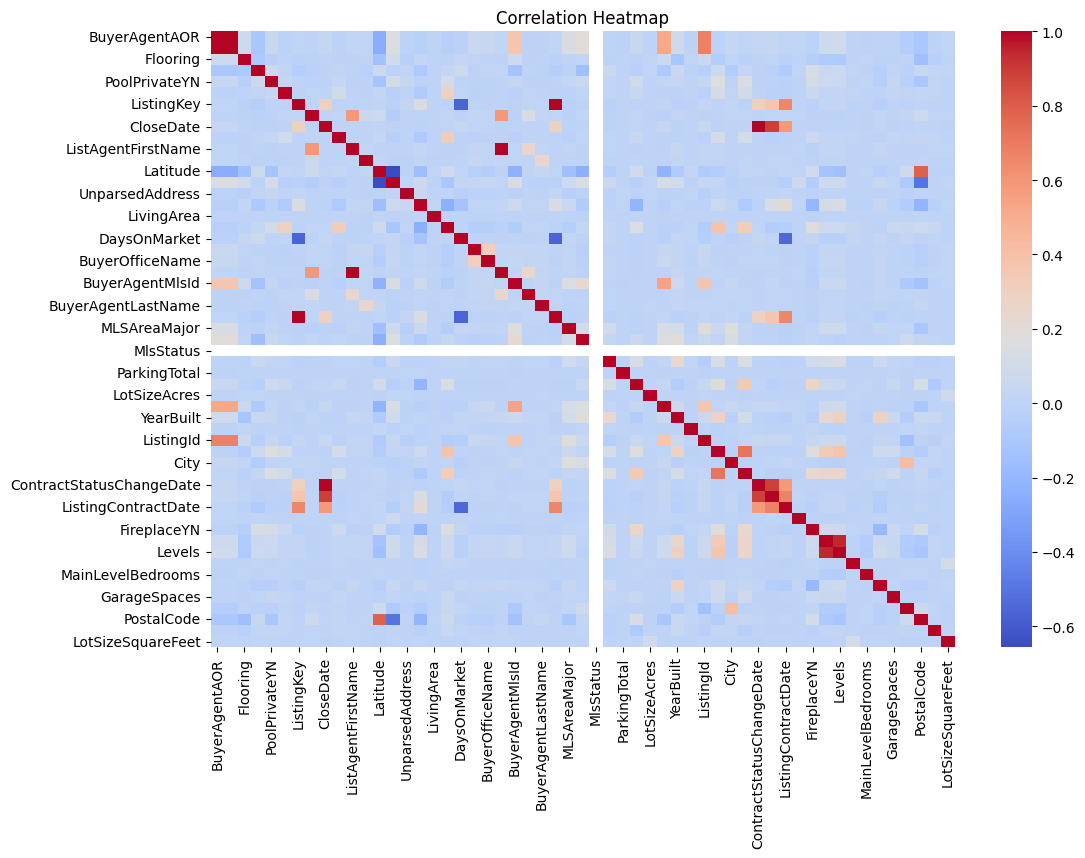

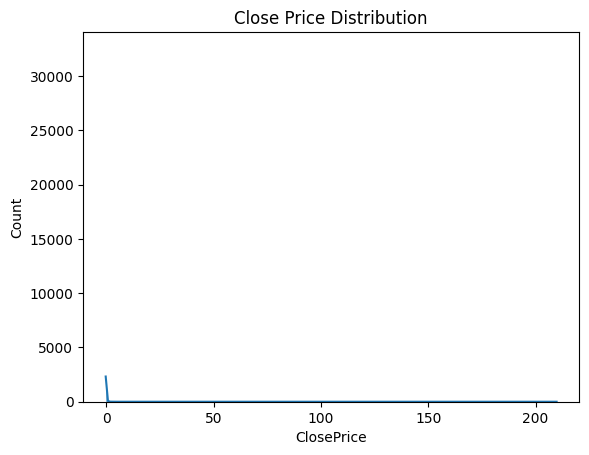

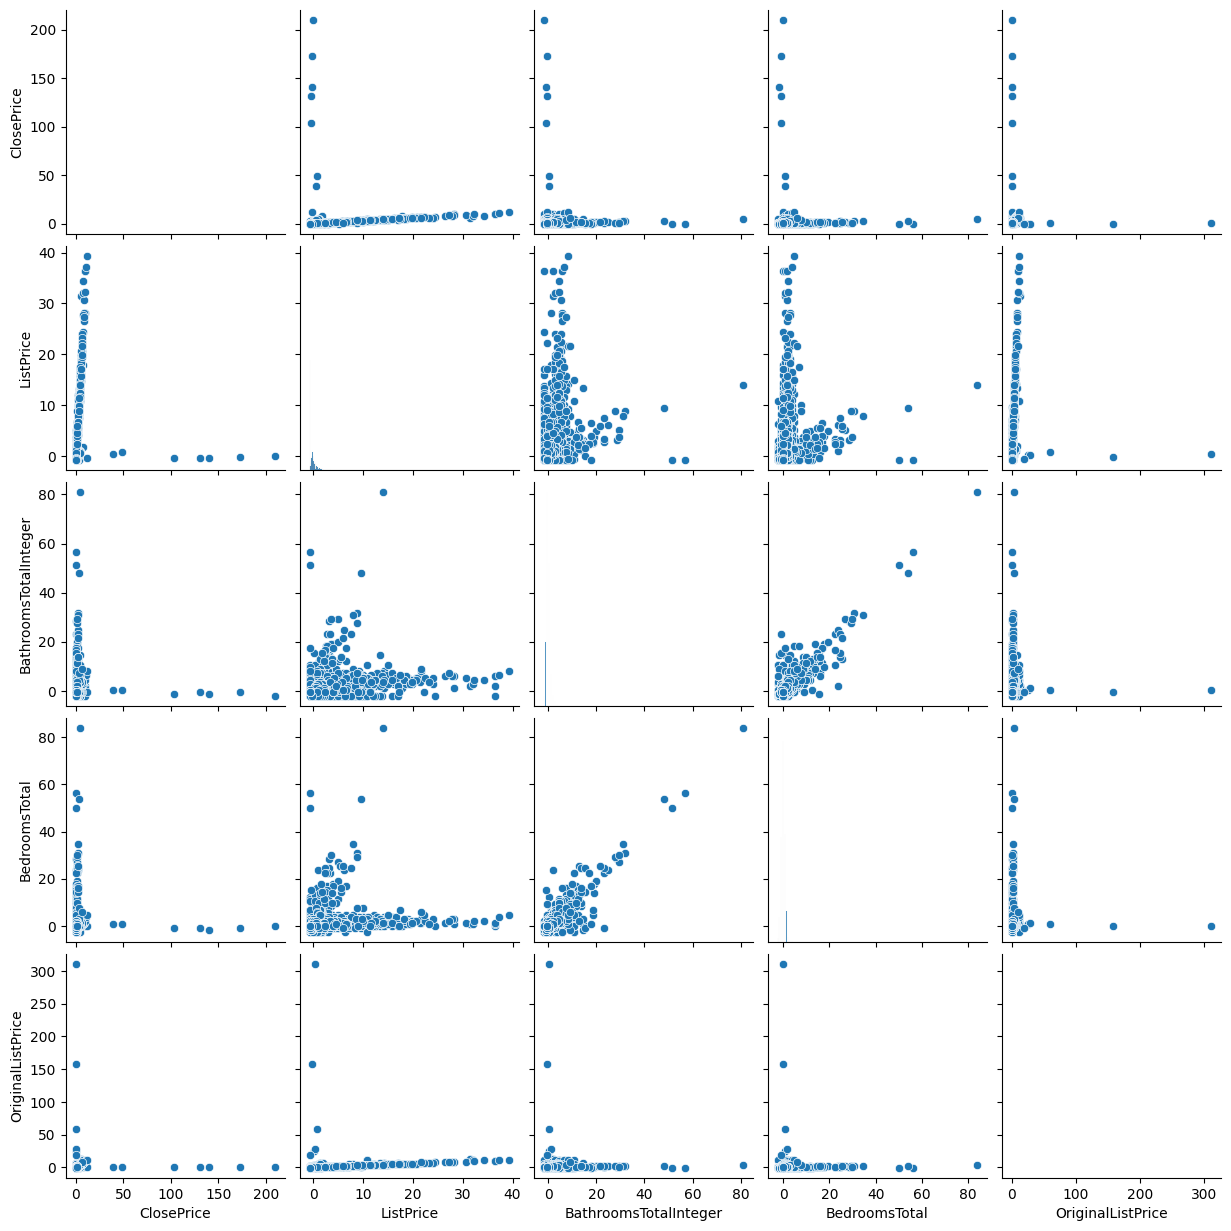

In [20]:
# Data Exploration
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(crmls_data.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Target distribution (close price)
sns.histplot(crmls_data['ClosePrice'], kde=True)
plt.title("Close Price Distribution")
plt.show()

# Pairplot of the top correlated features with closeprice
top_corr_features = crmls_data.corr().nlargest(5, 'ClosePrice')['ClosePrice'].index
sns.pairplot(crmls_data[top_corr_features])
plt.show()

- Red (close to +1): Strong positive correlation – as one variable increases, the other also increases.
- Blue (close to -1): Strong negative correlation – as one variable increases, the other decreases.
- White (near 0): Little to no correlation.

- LotSizeSquareFeet and LotSizeAcres likely have a strong positive correlation since they represent similar attributes, do we want to remove one?




- The distribution seems to be heavily skewed, with most of the data concentrated at lower values and a long tail extending to higher values. This indicates that outliers or extreme values in ClosePrice may exist.
- Do we want to consider applying a transformation (e.g., log transformation) to reduce skewness and improve model performance?


Diagonal:
- These show the distributions (histograms) of each feature.
- The distributions for ClosePrice, ListPrice, and OriginalListPrice appear heavily skewed with long tails. (Should we remove ListPrice and OriginalListPrice?)

Scatterplots:
ClosePrice vs ListPrice and ClosePrice vs OriginalListPrice:
- These exhibit a positive linear trend, indicating that as the list price or original list price increases, the close price also tends to increase. This is expected since these prices are closely related.

ClosePrice vs BathroomsTotalInteger and ClosePrice vs BedroomsTotal:
- The relationships here appear less linear. For example:
- Properties with a higher number of bathrooms or bedrooms show a wider spread of close prices, but close prices tend to plateau after a certain point.
- There are clusters indicating most properties have lower numbers of bathrooms/bedrooms.

Outliers:
- The plots suggest the presence of outliers, particularly in variables like OriginalListPrice, where certain points are significantly higher than the majority of data.
- These extreme values may influence correlations and models.

Next Steps:
Data Transformation:
- Consider applying a log or square root transformation to ClosePrice, ListPrice, and OriginalListPrice to address skewness.

Outlier Treatment:
- Review the outliers in features like OriginalListPrice and decide whether to cap them, remove them, or investigate further.

Feature Selection:
- While ListPrice and OriginalListPrice are highly correlated, including both in a model may lead to multicollinearity issues. You may drop one.

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Step 1: Select relevant features
correlation_matrix = crmls_data.corr()
close_price_corr = correlation_matrix["ClosePrice"].abs().sort_values(ascending=False)
threshold = 0.3
relevant_features = close_price_corr[close_price_corr > threshold].index.tolist()

# Ensure 'ClosePrice' is the target variable and remove it from features
if 'ClosePrice' in relevant_features:
    relevant_features.remove('ClosePrice')

# Step 2: Split the data
X = crmls_data[relevant_features]
y = crmls_data['ClosePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Build the pipeline
# Preprocessing: Scale the features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), relevant_features)
    ],
    remainder='passthrough'  # Keep any remaining columns as they are
)

# Model: Random Forest Regressor
model = RandomForestRegressor(random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Step 4: Train and evaluate the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Optional: Feature Importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': relevant_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)



Mean Squared Error: 0.033790835342833656
Feature Importances:
     Feature  Importance
0  ListPrice         1.0


Model Refinement:

- Drop Redundant Features: If ListPrice is too dominant and its relationship to ClosePrice is trivial, consider removing it from the dataset. This will allow the model to explore other predictors for subtle patterns.

- Feature Engineering: Transform features like BathroomsTotalInteger, BedroomsTotal, etc., or derive ratios and interactions that might add more predictive value (e.g., price_per_bedroom or price_per_square_foot).

- Regularization: Try a model like Gradient Boosting, XGBoost, or Lasso Regression, which can penalize dominant features and encourage the use of others.

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Select relevant features (with fallback if empty)
correlation_matrix = crmls_data.corr()
close_price_corr = correlation_matrix["ClosePrice"].abs().sort_values(ascending=False)

threshold = 0.3
relevant_features = close_price_corr[close_price_corr > threshold].index.tolist()

# Ensure 'ClosePrice' is the target variable and remove it from features
if 'ClosePrice' in relevant_features:
    relevant_features.remove('ClosePrice')

# Exclude 'ListPrice' from features
if 'ListPrice' in relevant_features:
    relevant_features.remove('ListPrice')

# Fallback if no relevant features are selected
if not relevant_features:
    relevant_features = crmls_data.columns.drop('ClosePrice').tolist()
    print("Fallback to all features except ClosePrice.")

print("Relevant Features:", relevant_features)

# Step 2: Split the data
X = crmls_data[relevant_features]
y = crmls_data['ClosePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), relevant_features)
    ],
    remainder='passthrough'  # Keep any remaining columns as they are
)

# Model: Random Forest Regressor
model = RandomForestRegressor(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Step 4: Cross-validation to assess performance
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_mse = -cv_scores.mean()  # Take the negative to get the MSE
print("Mean Cross-Validated MSE:", mean_cv_mse)

# Step 5: Train and evaluate the pipeline
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Test Set Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

# Step 6: Feature Importance
importances = pipeline.named_steps['model'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': relevant_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances after dropping 'ListPrice':")
print(feature_importance_df)


Fallback to all features except ClosePrice.
Relevant Features: ['BuyerAgentAOR', 'ListAgentAOR', 'Flooring', 'ViewYN', 'PoolPrivateYN', 'OriginalListPrice', 'ListingKey', 'ListAgentEmail', 'CloseDate', 'ListAgentFirstName', 'ListAgentLastName', 'Latitude', 'Longitude', 'UnparsedAddress', 'PropertyType', 'LivingArea', 'ListPrice', 'DaysOnMarket', 'ListOfficeName', 'BuyerOfficeName', 'ListAgentFullName', 'BuyerAgentMlsId', 'BuyerAgentFirstName', 'BuyerAgentLastName', 'ListingKeyNumeric', 'MLSAreaMajor', 'CountyOrParish', 'MlsStatus', 'AttachedGarageYN', 'ParkingTotal', 'PropertySubType', 'LotSizeAcres', 'BuyerOfficeAOR', 'YearBuilt', 'StreetNumberNumeric', 'ListingId', 'BathroomsTotalInteger', 'City', 'BedroomsTotal', 'ContractStatusChangeDate', 'PurchaseContractDate', 'ListingContractDate', 'StateOrProvince', 'FireplaceYN', 'Stories', 'Levels', 'LotSizeArea', 'MainLevelBedrooms', 'NewConstructionYN', 'GarageSpaces', 'HighSchoolDistrict', 'PostalCode', 'AssociationFee', 'LotSizeSquareFee

KeyboardInterrupt: 

Linear Regression: MSE = 0.00, R2 Score = 0.9609
Decision Tree: MSE = 3.15, R2 Score = -30.3558
Random Forest: MSE = 0.48, R2 Score = -3.7979
Gradient Boosting: MSE = 0.02, R2 Score = 0.8411
Support Vector Machine: MSE = 0.01, R2 Score = 0.8906
                             MSE   R2 Score
Linear Regression       0.003927   0.960919
Decision Tree           3.150750 -30.355766
Random Forest           0.482117  -3.797949
Gradient Boosting       0.015966   0.841105
Support Vector Machine  0.010992   0.890611


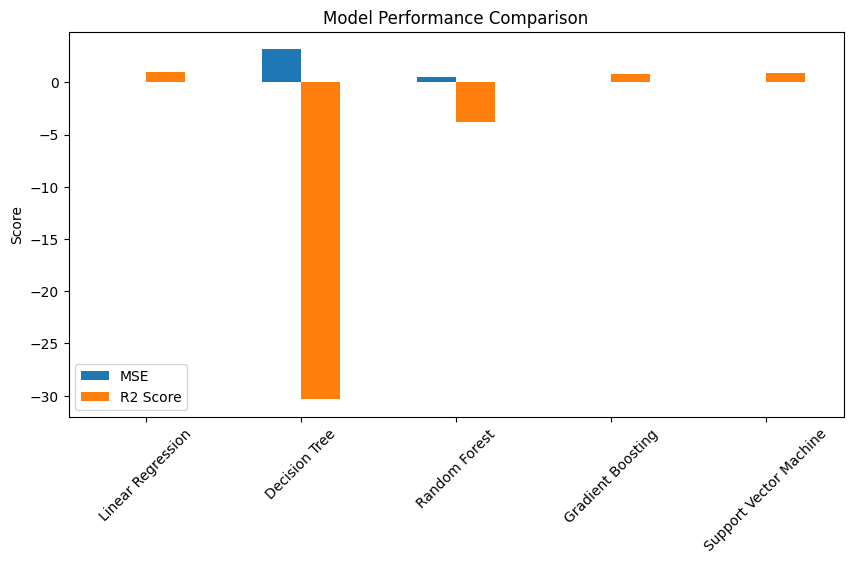

In [19]:
# Splitting features and target
X = crmls_data.drop(columns=['ClosePrice'])
y = crmls_data['ClosePrice']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Machine': SVR()
}

# Training and evaluating models
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2 Score': r2}
    print(f'{name}: MSE = {mse:.2f}, R2 Score = {r2:.4f}')

# Comparing model performance
results_crmls_data = pd.DataFrame(results).T
print(results_crmls_data)

# Visualizing model performance
results_crmls_data.plot(kind='bar', figsize=(10, 5))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

The output provides an evaluation of five machine learning models applied to a regression problem where the goal is to predict the ClosePrice based on other features in your dataset. Let's break it down:

Metrics:

1.) Mean Squared Error (MSE):
- Measures the average squared difference between the actual and predicted values.
- Lower values indicate better performance (closer to the true values).

2.)R² Score (Coefficient of Determination):
- Indicates the proportion of variance in the target variable explained by the model.
- Values range from:
    - 1: Perfect prediction.
    - 0: The model does no better than predicting the mean.
    - Negative values: The model performs worse than predicting the mean.


Interpretation of Results:

1.) Linear Regression:
- MSE = 0.00, R² = 0.9609
- This model explains 96.1% of the variance in the target variable, indicating excellent performance.
- The very low MSE shows its predictions are close to the actual values.

2.) Decision Tree:
- MSE = 3.15, R² = -30.36
- The model performs extremely poorly, as indicated by a large MSE and a negative R².
- A negative R² suggests the model is worse than simply predicting the mean of ClosePrice.
- Likely causes:
    - Overfitting on the training data.
    - Poor generalization to unseen test data.
    - Inappropriate hyperparameter tuning.

3.) Random Forest:
- MSE = 0.48, R² = -3.80
- Despite being an ensemble method, this model also performs poorly, though not as badly as the Decision Tree.
- Similar issues with generalization or hyperparameter tuning might be present.

4.) Gradient Boosting:
- MSE = 0.02, R² = 0.8411
- Performs well, explaining 84.1% of the variance, though not as well as Linear Regression.
- A relatively low MSE suggests it's making decent predictions, but it's slightly less accurate.

5.) Support Vector Machine (SVM):
- MSE = 0.01, R² = 0.8906
- - Performs better than Gradient Boosting, explaining 89.1% of the variance.
Slightly higher MSE than Linear Regression but better than Gradient Boosting.


Key Takeaways:

Linear Regression is the best model in this case:
- It achieves the highest R² (0.9609) and lowest MSE (0.00).
- This suggests the relationship between the predictors and the target is likely linear, which aligns well with the simplicity of the Linear Regression model.

Decision Tree and Random Forest perform poorly:
- Both models have negative R² values, indicating they fail to generalize well to the test data.
- This could be due to hyperparameter tuning issues (e.g., tree depth, number of estimators) or inappropriate features in the dataset.

Gradient Boosting and SVM also perform well:
- These models achieve reasonably high R² scores and low MSE values.
- They are more flexible and complex than Linear Regression but slightly less optimal for this specific dataset.

Improve by:

Focus on Linear Regression:
- It appears to be the most suitable model for this dataset.
- Simpler models often perform better when the relationship between predictors and the target is linear.

Investigate Decision Tree and Random Forest Issues:
- Check if hyperparameters (e.g., tree depth, number of estimators, minimum samples per leaf) are tuned appropriately.
- Ensure no data leakage or issues with feature scaling, as these models can be sensitive.

Feature Engineering and Selection:
- Explore if the dataset has noisy or irrelevant features affecting Decision Tree and Random Forest models.
- Consider dropping less important features and re-evaluating.

Experiment with Hyperparameters:
- Particularly for Gradient Boosting and Random Forest, fine-tuning parameters such as the learning rate, number of estimators, and max depth might improve performance.

Cross-Validation:
- Use k-fold cross-validation to ensure robust evaluation and prevent overfitting.

R² Score: 0.7255
Mean Absolute Error (MAE): 0.02
Root Mean Squared Error (RMSE): 0.17


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/x9/n1qbsm8n6n12cw26bm0qdsdc0000gn/T/ipykernel_7941/3949203332.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="features", data=rf_importance_df_trim, palette='viridis')


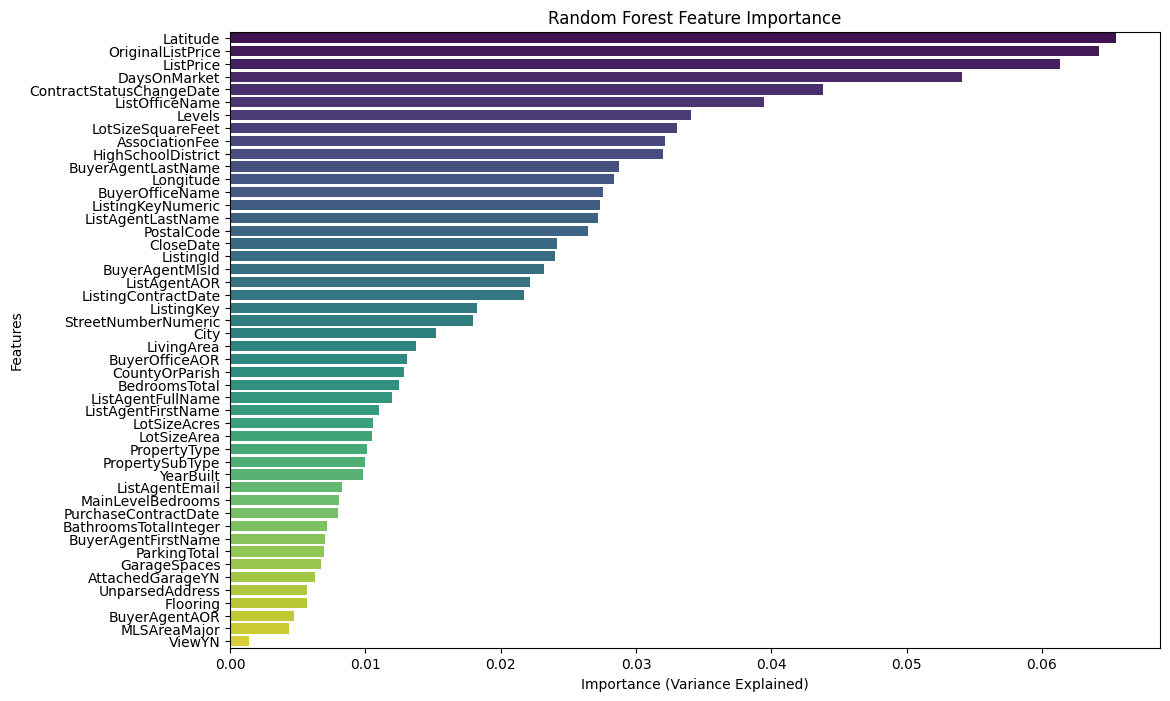

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Split the dataset into features (X) and target variable (y)
X = crmls_data.drop(columns=['ClosePrice'])  # 'ClosePrice' is the target variable
y = crmls_data['ClosePrice']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluate the model
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Root Mean Squared Error (RMSE): {mean_squared_error(y_test, y_pred, squared=False):.2f}")

# Feature importance analysis
rf_importance = rf.feature_importances_
rf_importance_df = pd.DataFrame({'features': X_train.columns, 'importance': rf_importance})
rf_importance_df.sort_values('importance', ascending=False, inplace=True)

# Filter top features
rf_importance_df_trim = rf_importance_df[rf_importance_df['importance'] > 0.001]

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="features", data=rf_importance_df_trim, palette='viridis')
plt.xlabel("Importance (Variance Explained)")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.show()


Random Forest model results show:

- R² Score = 0.7255 → The model explains 72.55% of the variance in house prices, which is a decent fit but has room for improvement.
- Mean Absolute Error (MAE) = 0.02 → On average, predictions are off by 2% of the price (assuming scaled data).
- Root Mean Squared Error (RMSE) = 0.17 → Average error magnitude is 0.17 in scaled terms (interpret based on data scaling).